In [184]:
%matplotlib inline

Model Zoo: https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/model_zoo.md

## DeepLab Model

In [188]:
!git clone https://github.com/tensorflow/models
# From tensorflow/models/research/
!cd models/research/
!export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim

fatal: destination path 'models' already exists and is not an empty directory.


Following Code Taken From:
https://colab.research.google.com/github/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb#scrollTo=kAbdmRmvq0Je

In [189]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

In [15]:

class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()

#######
# changed for cityscape labels
#LABEL_NAMES = np.asarray([trainId2label[i].name for i in np.arange(19)])
LABEL_NAMES = np.asarray(['road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
       'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky',
       'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle',
       'bicycle'])
#######

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [195]:
# Changed to explicitly pick just a chosen model
_TARBALL_NAME = 'deeplab_model.tar.gz'
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
#deeplab_cityscapes_xception71_trainfine_2018_09_08
#mobilenetv2_coco_cityscapes_trainfine
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
                   download_path)

print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


img_folder = '/home/project/data/Cityscapes/leftImg8bit/val/frankfurt'
img_names = os.listdir(img_folder)
img = skimage.io.imread(img_folder + '/' + random.choice(img_names))
skimage.io.imshow(img)

In [196]:
import os
import glob

d = '../cityscapes/leftImg8bit/val'
cities = [os.path.join(d, o) for o in os.listdir(d) 
                    if os.path.isdir(os.path.join(d,o))]
fileImg = ""
for c in cities:
    files = glob.glob(c + '/*.png')
    #print(files)
    for file in files:
        fileImg = file
    break
print(fileImg)
print(len(cities))
#cityscapes/gtFine/train/strasbourg/strasbourg_000000_000065_gtFine_instanceIds.png

../cityscapes/leftImg8bit/val/munster/munster_000170_000019_leftImg8bit.png
3


In [76]:
!pip install --upgrade pip
!pip install opencv-python

    100% |████████████████████████████████| 1.3MB 25.7MB/s ta 0:00:01
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1


In [198]:
import os
import glob
import numpy
import json
import PIL.ImageDraw as ImageDraw,PIL.Image as Image, PIL.ImageShow as ImageShow 
from pprint import pprint
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

labelList = ['road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
       'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky',
       'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle',
       'bicycle']
colormap = create_pascal_label_colormap()

SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = 'https://i1.wp.com/www.totaltaipei.com/wp-content/uploads/2017/04/fake-accident.jpg?fit=600%2C303'

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')


def run_visualization(url):
    """Inferences DeepLab model and visualizes result."""
    
    file_name = os.path.basename(url).replace("_leftImg8bit.png", ".png")
    try:
        original_im = Image.open(url)
        url = url.replace("leftImg8bit/", "gtFine/")
        url = url.replace("leftImg8bit.png", "gtFine_labelIds.png")
        training_label = Image.open(url)
        
        url = url.replace("gtFine_labelIds.png", "gtFine_polygons.json")
        with open(url) as f:
            data = json.load(f)
        
    except IOError:
        print('Cannot retrieve image. Please check url: ' + url)
        return

    print('running deeplab on image %s...' % url)
    resized_im, seg_map = MODEL.run(original_im)
    #vis_segmentation(resized_im, seg_map)
    seg_map = label_to_color_image(seg_map).astype(np.uint8)
    #training_label.thumbnail(resized_im.size, Image.ANTIALIAS)
    #training_label = numpy.array(training_label)
    #training_label = label_to_color_image(training_label).astype(np.uint8)
    imgHeight = data["imgHeight"]
    imgWidth = data["imgWidth"]
    objects = data["objects"]
    #print(resized_im.size)
    trainings_data_size = (imgWidth, imgHeight)
    
    trainingImage = Image.new("RGB", trainings_data_size)
    draw = ImageDraw.Draw(trainingImage)
    for i, obj in enumerate(objects):
        #print(obj["label"])
        label = obj["label"]
        if label in labelList:
            colorIdx = labelList.index(label)
            #print(colormap[colorIdx])
            #colormap[label]
            ptsArr = obj["polygon"]   
            
            tt = []
            for t in ptsArr:
                tt.append((t[0], t[1]))
            col = (colormap[colorIdx][0], colormap[colorIdx][1], colormap[colorIdx][2])
            draw.polygon(tt ,fill=col)
            

    #plt.title("original")
    #plt.imshow(original_im)
    #plt.show()
    #plt.title("computed label")
    
    #img = cv2.imread('your_image.jpg')
    seg_map = cv2.resize(seg_map, dsize=trainings_data_size, interpolation=cv2.INTER_NEAREST)
    
    seg_map = Image.fromarray(seg_map.astype('uint8'))
    #seg_map = seg_map.thumbnail(trainings_data_size)
    #print(trainings_data_size)
    #plt.imshow(seg_map)
    #plt.show()
    #plt.title("training label")    
    #plt.imshow(trainingImage)
    #plt.show()
    
    p1 = seg_map.load() 
    p2 = trainingImage.load()
    #print(p1[0,0])
    #print(p2[0,0])
    
    diffIm = Image.new("RGB", trainings_data_size)
    draw = ImageDraw.Draw(trainingImage)
    pr = diffIm.load()

    for i in range(diffIm.size[0]): # for every pixel:
        for j in range(diffIm.size[1]):
            if p1[i,j] != p2[i,j]:
                pr[i,j] = (255, 255 ,255)
    #plt.title("compared image")    
    #plt.imshow(diffIm)
    #plt.show()
    
    
    original_im.save("validation2/" + file_name, "PNG")
    
    seg_map.save("validation2/" + file_name.replace(".png", "_seg.png"))    
    #training_label = Image.fromarray(training_label)
    trainingImage.save("validation2/" + file_name.replace(".png", "_train.png"), "PNG")   
    diffIm.save("validation2/" + file_name.replace(".png", "_diff.png"), "PNG")   
  

d = '../cityscapes/leftImg8bit/val'
cities = [os.path.join(d, o) for o in os.listdir(d) 
                    if os.path.isdir(os.path.join(d,o))]
fileImg = ""
for c in cities:
    files = glob.glob(c + '/*.png')
    #print(files)
    for file in files:
        fileImg = file
        image_url = fileImg
        run_visualization(image_url)
    break

#image_url = fileImg
#run_visualization(image_url)

running deeplab on image ../cityscapes/gtFine/val/munster/munster_000144_000019_gtFine_polygons.json...
running deeplab on image ../cityscapes/gtFine/val/munster/munster_000049_000019_gtFine_polygons.json...
running deeplab on image ../cityscapes/gtFine/val/munster/munster_000037_000019_gtFine_polygons.json...
running deeplab on image ../cityscapes/gtFine/val/munster/munster_000146_000019_gtFine_polygons.json...
running deeplab on image ../cityscapes/gtFine/val/munster/munster_000130_000019_gtFine_polygons.json...
running deeplab on image ../cityscapes/gtFine/val/munster/munster_000090_000019_gtFine_polygons.json...
running deeplab on image ../cityscapes/gtFine/val/munster/munster_000073_000019_gtFine_polygons.json...
running deeplab on image ../cityscapes/gtFine/val/munster/munster_000036_000019_gtFine_polygons.json...
running deeplab on image ../cityscapes/gtFine/val/munster/munster_000155_000019_gtFine_polygons.json...
running deeplab on image ../cityscapes/gtFine/val/munster/munste

KeyboardInterrupt: 

[(200, 100), (300, 200), (400, 150)]


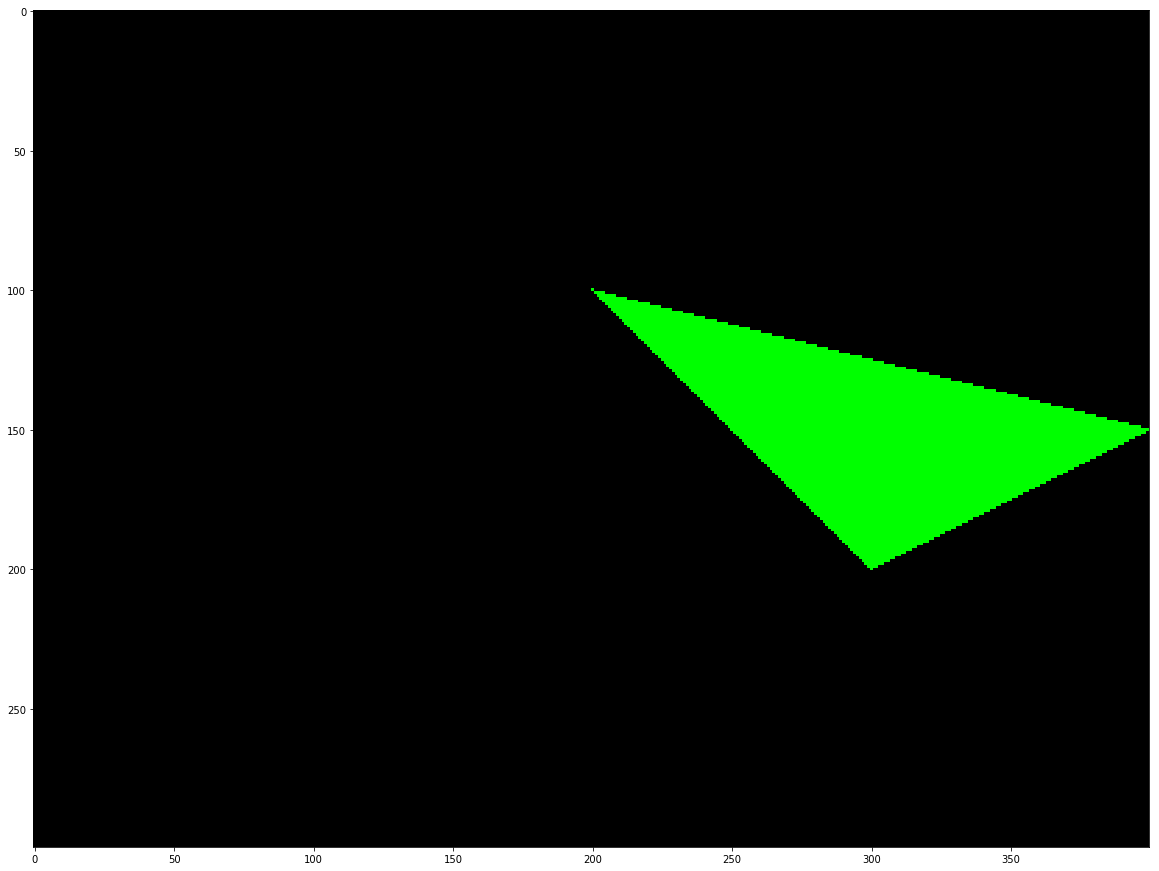

In [153]:
import PIL.ImageDraw as ImageDraw,PIL.Image as Image, PIL.ImageShow as ImageShow 
im = Image.new("RGB", (400,300))
draw = ImageDraw.Draw(im)
tt = []
tt.append((200,100))
tt.append((300,200))
tt.append((400,150))
print(tt)
draw.polygon(tt ,fill=(0, 255, 0))

plt.imshow(im)
plt.show()

In [199]:
#!/usr/bin/env python
import os
import zipfile

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

zipf = zipfile.ZipFile('validationMunster2.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('validation2/', zipf)
zipf.close()